In [1]:
import torch, time, copy
import torch.nn as nn
import torch.optim as optim
from torch.quantization import prepare, convert
from src.utils import *
from src.override_resnet import *
import matplotlib.pyplot as plt


In [2]:
device = "cuda"
model = resnet50_quan(weights=resnet.ResNet50_Weights.DEFAULT)
model.to(device)
model.eval()

# set fuse ############################################################
model = fuse_ALL(model)

model.fc.qconfig = torch.quantization.QConfig(
    activation=torch.quantization.default_debug_observer,
    weight=None,
)


for name, module in model.named_modules():
    # print(name)
    # if hasattr(module, "qconfig"):
    #     if module.qconfig is not None:
    #         print(f"{name} | {module.qconfig}")
    if len(name) > 2 and name[-5:] == "relu3":

        module.qconfig = torch.quantization.QConfig(
            activation=torch.quantization.default_debug_observer,
            weight=None,
        )
        print(f"{name} | {module.qconfig}")

layer1.0.relu3 | QConfig(activation=<class 'torch.ao.quantization.observer.RecordingObserver'>, weight=None)
layer1.1.relu3 | QConfig(activation=<class 'torch.ao.quantization.observer.RecordingObserver'>, weight=None)
layer1.2.relu3 | QConfig(activation=<class 'torch.ao.quantization.observer.RecordingObserver'>, weight=None)
layer2.0.relu3 | QConfig(activation=<class 'torch.ao.quantization.observer.RecordingObserver'>, weight=None)
layer2.1.relu3 | QConfig(activation=<class 'torch.ao.quantization.observer.RecordingObserver'>, weight=None)
layer2.2.relu3 | QConfig(activation=<class 'torch.ao.quantization.observer.RecordingObserver'>, weight=None)
layer2.3.relu3 | QConfig(activation=<class 'torch.ao.quantization.observer.RecordingObserver'>, weight=None)
layer3.0.relu3 | QConfig(activation=<class 'torch.ao.quantization.observer.RecordingObserver'>, weight=None)
layer3.1.relu3 | QConfig(activation=<class 'torch.ao.quantization.observer.RecordingObserver'>, weight=None)
layer3.2.relu3 | QC

In [3]:
prepare(model, inplace=True)

ResNet_quan(
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
  )
  (bn1): Identity()
  (relu): Identity()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck_quan(
      (conv1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
      )
      (bn1): Identity()
      (conv2): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (bn2): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): Identity()
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): Identity()
      )
      (relu1): Identity()
      (relu2): Identity()
      (relu3): ReLU()
    )
    (1): BottleNeck_quan(
      (con

In [4]:

# calibrate the model ############################################################
criterion = nn.CrossEntropyLoss()
batch_size = 25
train_loader, _ = GetDataset(
    dataset_name="ImageNet",
    device=device,
    root="data",
    batch_size=batch_size,
    num_workers=8,
)

limit = int(1000 / batch_size)
with torch.no_grad():
    for images, _ in tqdm.tqdm(train_loader):
        images = images.to(device)
        _ = model(images)

        limit -= 1
        if limit == 0:
            break

  0%|          | 39/51247 [00:01<37:31, 22.75it/s]  


40
25
1000
torch.Size([1000000])


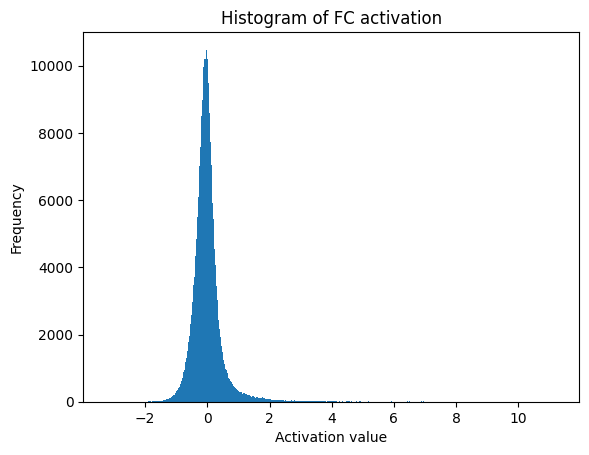

In [5]:
dja = model.fc.activation_post_process.get_tensor_value()
print(len(dja))
print(len(dja[0]))
print(len(dja[0][0]))
# print(len(dja[0][0][0])) // Not exist
# Assuming 'dja' is a list containing PyTorch tensors
dja = [tensor.to("cpu") for tensor in dja]
dja = torch.cat(dja).flatten()
print(dja.shape)
plt.hist(dja, bins=2048)
plt.title("Histogram of FC activation")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
plt.show()

5 * 32 * 1000 * 50 * 32 / 4 = 6.4GB

In [6]:
model.layer1[0].relu3

ReLU()

In [7]:
dja = model.layer1[0].relu3.get_tensor_value()
print(len(dja))
print(len(dja[0]))
print(len(dja[0][0]))
# print(len(dja[0][0][0])) // Not exist
# Assuming 'dja' is a list containing PyTorch tensors
dja = [tensor.to("cpu") for tensor in dja]
dja = torch.cat(dja).flatten()
print(dja.shape)
plt.hist(dja, bins=2048)
plt.title("Histogram of FC activation")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
plt.show()

AttributeError: 'ReLU' object has no attribute 'get_tensor_value'